In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,BatchNormalization, Flatten, Dense, Dropout

In [ ]:
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']

X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/MRI BTD Classification dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:51<00:00,  1.43it/s]


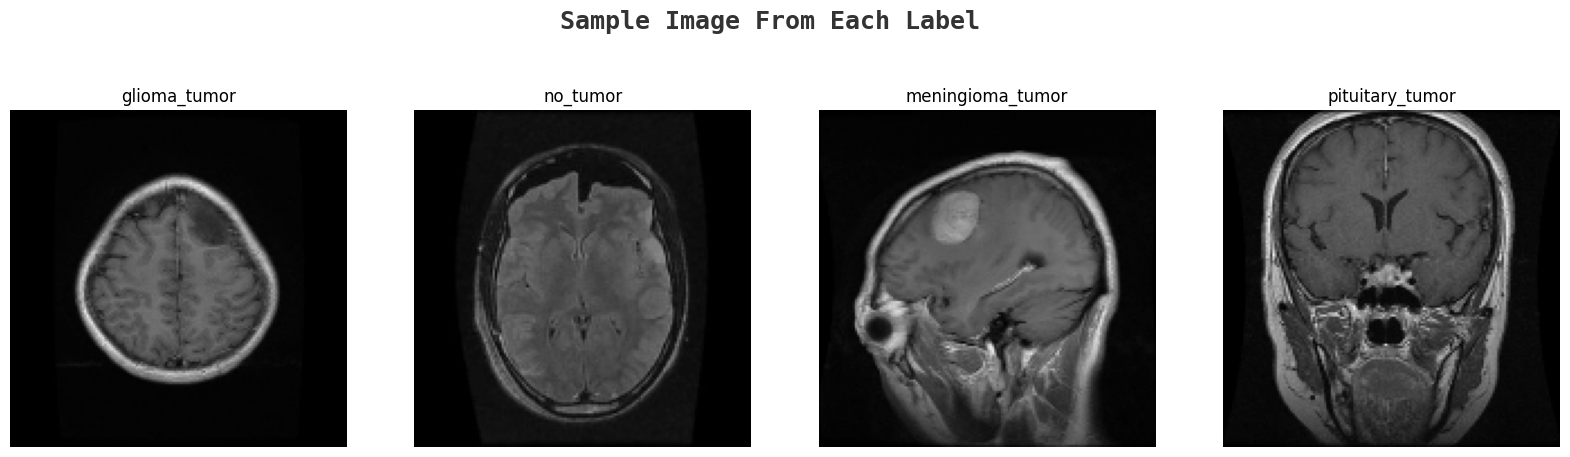

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [ ]:
X_train.shape

(2946, 150, 150, 3)

In [ ]:
X_test.shape

(328, 150, 150, 3)

In [ ]:
y_train.shape

(2946,)

In [ ]:
y_test.shape

(328,)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)

# Find unique class labels
unique_labels = np.unique(y_test_labels)

print("Unique class labels:", unique_labels)

Unique class labels: [0 1 2 3]


In [ ]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.787384 to fit



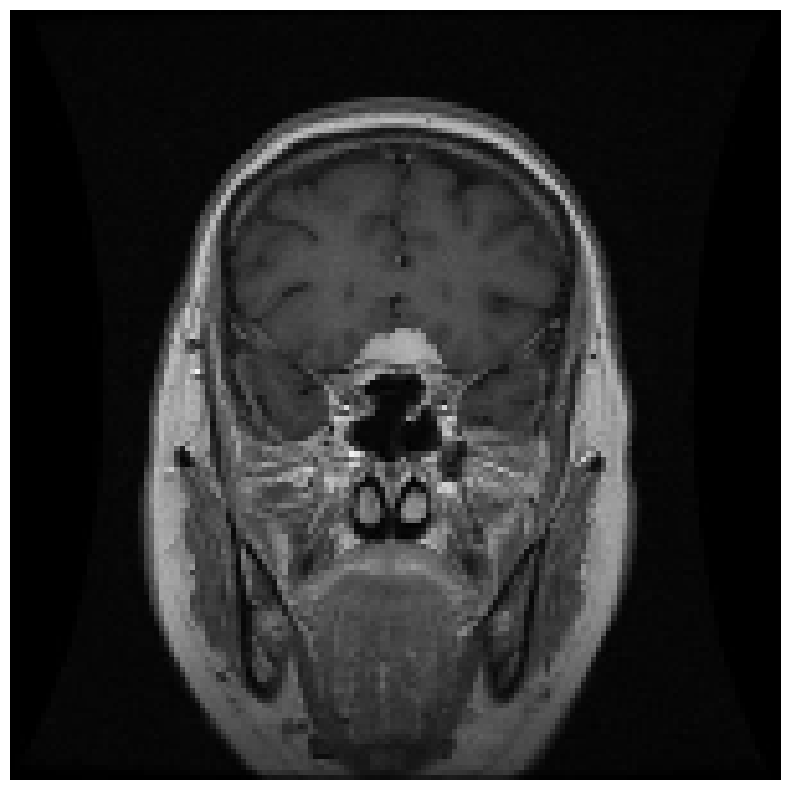

In [ ]:
plot_model(model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
83/83 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.8193
Epoch 1: val_accuracy improved from -inf to 0.75932, saving model to effnet.keras
83/83 [==============================] - 65s 254ms/step - loss: 0.4927 - accuracy: 0.8193 - val_loss: 0.9334 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 2/5
83/83 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9291
Epoch 2: val_accuracy improved from 0.75932 to 0.94915, saving model to effnet.keras
83/83 [==============================] - 12s 143ms/step - loss: 0.2011 - accuracy: 0.9291 - val_loss: 0.1793 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 3/5
83/83 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.9585
Epoch 3: val_accuracy did not improve from 0.94915
83/83 [==============================] - 11s 128ms/step - loss: 0.1300 - accuracy: 0.9585 - val_loss: 0.4963 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 4/5
83/83 [==============================] - ETA: 0s - loss: 0

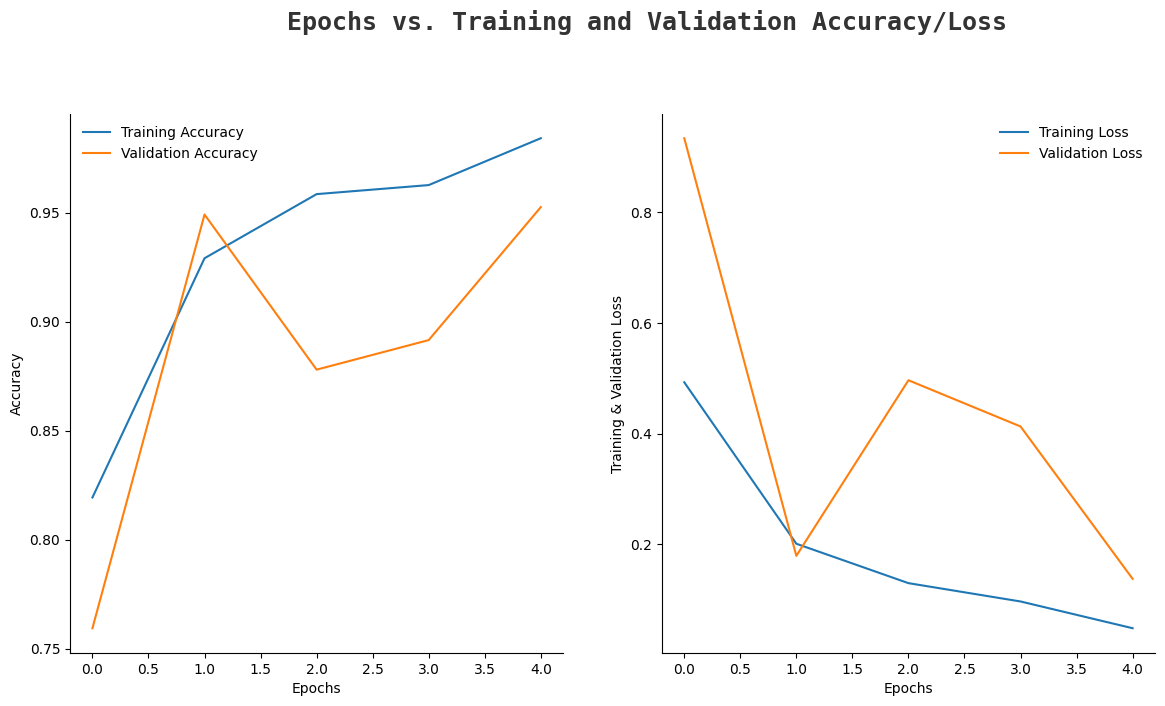

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(5)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 3s 127ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95        97
           1       0.96      0.98      0.97        51
           2       0.96      0.89      0.92        89
           3       0.95      1.00      0.97        91

    accuracy                           0.95       328
   macro avg       0.96      0.96      0.96       328
weighted avg       0.95      0.95      0.95       328



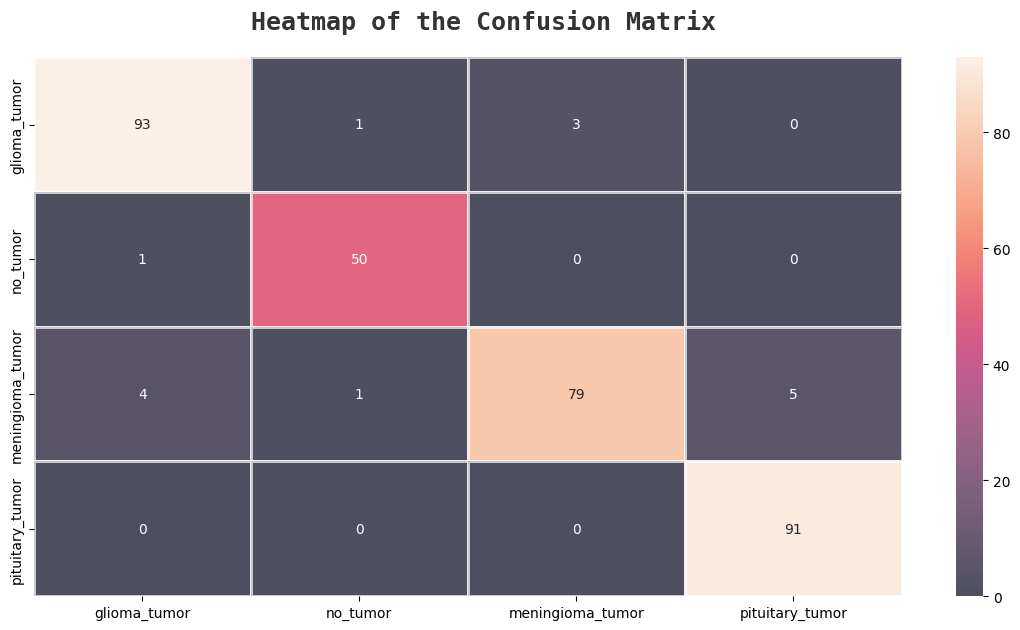

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

**Model**

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Example adjacency matrix (graph structure)
# Replace with your own graph data if applicable
adjacency_matrix = tf.constant([[0, 1, 0, 1],
                                [1, 0, 1, 0],
                                [0, 1, 0, 1],
                                [1, 0, 1, 0]], dtype=tf.float32)

# Example node features (replace with your own node features)
node_features = tf.random.normal(shape=(4, 10))  # 4 nodes, 10-dimensional features

# Define the Graph Neural Network (GNN) model
def build_gnn_model(input_dim, hidden_units, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(hidden_units, activation='relu')(inputs)
    x = Dropout(0.2)(x)
    x = Dense(hidden_units // 2, activation='relu')(x)
    outputs = Dense(output_dim, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create a GNN model
gnn_model = build_gnn_model(node_features.shape[1], 64, 4)  # Adjust hidden_units as needed

# Compile the model
gnn_model.compile(optimizer=Adam(learning_rate=0.001),  # Use 'learning_rate'
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Print a summary of the model architecture
gnn_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,916 (11.39 KB)

 Trainable params: 2,916 (11.39 KB)

 Non-trainable params: 0 (0.00 B)

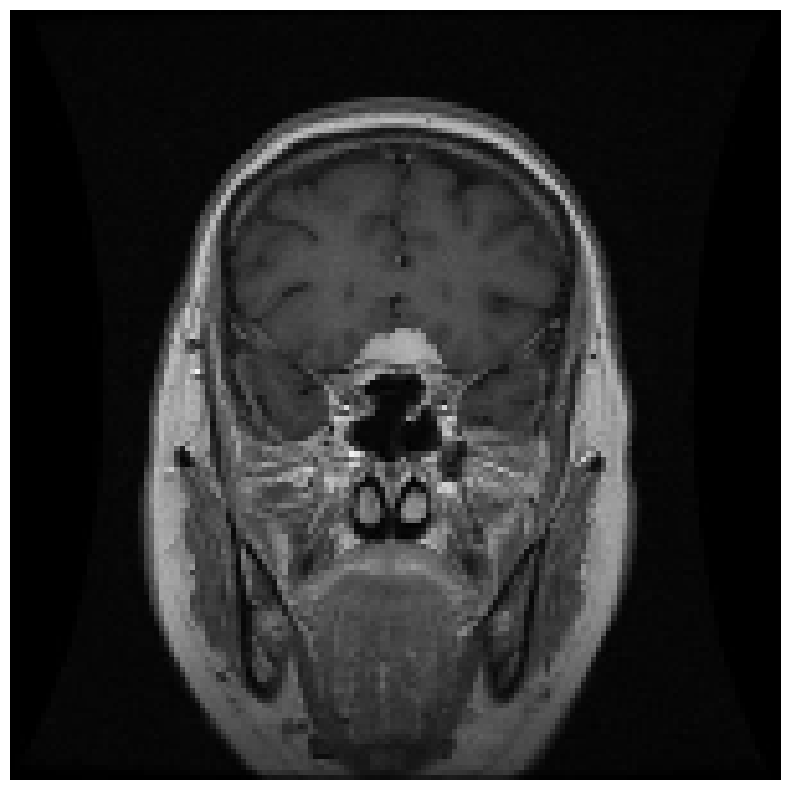

In [ ]:
plot_model(gnn_model, show_shapes=True, dpi=150)

# Display the plot
plt.figure(figsize=(20, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
resized_X_train = []
for img in X_train:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_train.append(resized_img)

resized_X_train = np.array(resized_X_train)

resized_X_test = []
for img in X_test:
    resized_img = cv2.resize(img, (224, 224))
    resized_X_test.append(resized_img)

resized_X_test = np.array(resized_X_test)

In [ ]:
gnn_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.layers import Flatten

def build_gnn_model(input_shape, hidden_units, output_dim):
    inputs = Input(shape=input_shape)
    x = Flatten()(inputs)  # Flatten the input images
    x = Dense(hidden_units, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(hidden_units // 2, activation='relu')(x)
    outputs = Dense(output_dim, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create a GNN model
gnn_model = build_gnn_model((224, 224, 3), 64, 4)  # Adjust hidden_units as needed

# Compile the model
gnn_model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
history = gnn_model.fit(resized_X_train,y_train,validation_split=0.1, epochs =30, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/30
81/83 [============================>.] - ETA: 0s - loss: 1.3658 - accuracy: 0.2851
Epoch 1: val_accuracy did not improve from 0.95254
83/83 [==============================] - 2s 21ms/step - loss: 1.3653 - accuracy: 0.2844 - val_loss: 1.3677 - val_accuracy: 0.2542 - lr: 8.1000e-06
Epoch 2/30
78/83 [===========================>..] - ETA: 0s - loss: 1.3658 - accuracy: 0.2857
Epoch 2: val_accuracy did not improve from 0.95254
83/83 [==============================] - 1s 9ms/step - loss: 1.3653 - accuracy: 0.2844 - val_loss: 1.3676 - val_accuracy: 0.2542 - lr: 8.1000e-06
Epoch 3/30
82/83 [============================>.] - ETA: 0s - loss: 1.3654 - accuracy: 0.2839
Epoch 3: val_accuracy did not improve from 0.95254

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
83/83 [==============================] - 1s 8ms/step - loss: 1.3653 - accuracy: 0.2844 - val_loss: 1.3676 - val_accuracy: 0.2542 - lr: 8.1000e-06
Epoch 4/30
79/83 [===========================>..]

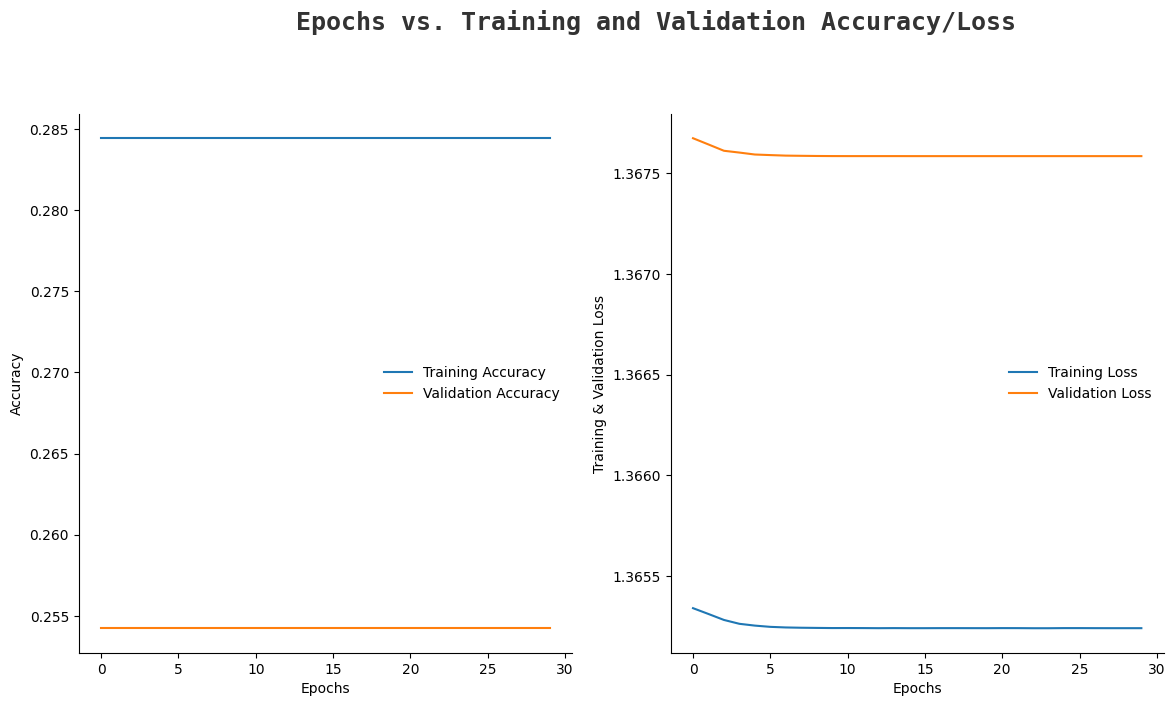

In [ ]:
filterwarnings('ignore')

# Adjust the range of epochs to match the training history
epochs = [i for i in range(len(history.history['accuracy']))]

fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold', fontname='monospace',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss,label ='Training Loss')
ax[1].plot(epochs, val_loss, label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = gnn_model.predict(resized_X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 0s 3ms/step


In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.30      1.00      0.46        97
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        89
           3       0.00      0.00      0.00        91

    accuracy                           0.30       328
   macro avg       0.07      0.25      0.11       328
weighted avg       0.09      0.30      0.13       328



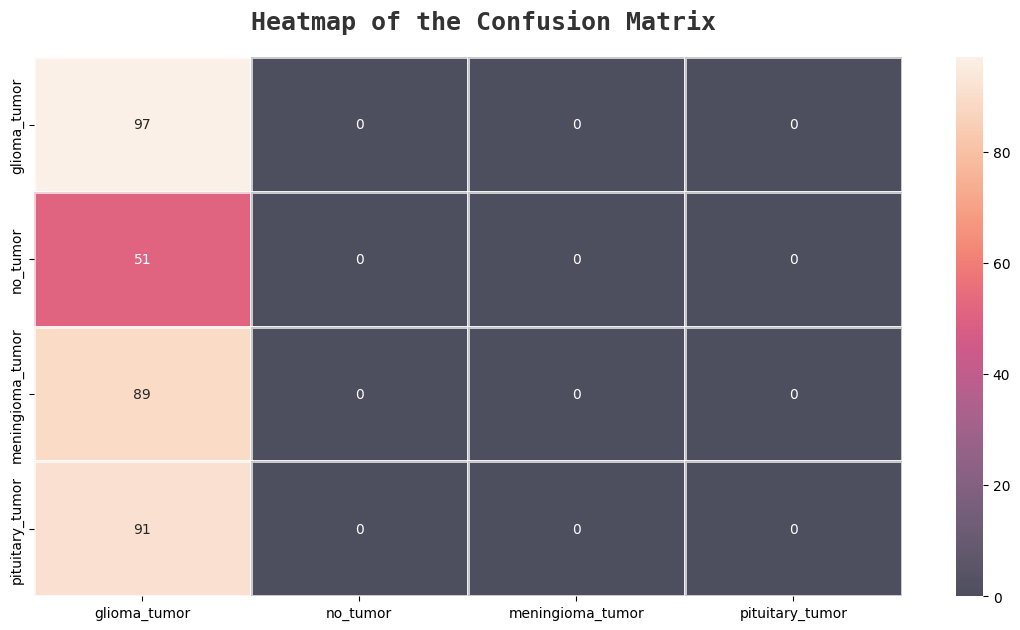

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
model.save("/content/drive/MyDrive/MRI_Model_Saved/brain_GNN.h5")